# display hindcast v2
    - hindcast simulation from 1991 to 2022
    - compare T/S climatology against World Ocean Atlas 2018
    - compare SST interannual variability against HadISST
    - compare SSH against AVISO SSH products

In [16]:
# Importing necessary libraries
import numpy as np                  # For numerical operations and arrays
import matplotlib.pyplot as plt     # For creating visualizations
import xarray as xr                 # For working with labeled multidimensional arrays and datasets
import xmitgcm as xm                # For interfacing with the MITgcm ocean model
import warnings                    # For managing warnings
warnings.filterwarnings('ignore')  # Ignore warning messages
import os                          # For interacting with the operating system
import pandas as pd                # For data manipulation and analysis

In [19]:
# Importing world ocean atlas 2018 datasets for temperature and salinity
ds_t = xr.open_dataset('/glade/campaign/univ/ugit0036/obs/woa2018/t/woa18_decav_t00_01.nc', decode_times=False)  # Temperature dataset
ds_s = xr.open_dataset('/glade/campaign/univ/ugit0036/obs/woa2018/s/woa18_decav_s00_01.nc', decode_times=False)  # Salinity dataset

# Selecting Gulf of Alaska region from the world ocean atlas datasets
ds_t_goa = ds_t.sel(lon=slice(-160,-120)).sel(lat=slice(42,62))  # Gulf of Alaska temperature dataset
ds_s_goa = ds_s.sel(lon=slice(-160,-120)).sel(lat=slice(42,62))  # Gulf of Alaska salinity dataset

# Importing HadISST dataset
ds_h = xr.open_dataset('/glade/campaign/univ/ugit0036/obs/HadISST_20230705/HadISST_sst.nc')  # HadISST dataset

# Setting the location of SSH dataset
fnh='/glade/campaign/univ/ugit0036/obs/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_'

In [22]:
# access the model output (phys_spinup)
run = ['hindcast_v2']
# for the first 1 year (72 time slices)
#com = 'ls /glade/scratch/ito/'+run[0]+'/2DdynDiag_mon.*.meta  > fn.txt'
com = 'ls /glade/campaign/univ/ugit0036/'+run[0]+'/2DdynDiag_mon.*.meta  > fn.txt'
os.system(com)
iters=np.genfromtxt('fn.txt',delimiter='.')
#ds0=xm.open_mdsdataset('/glade/scratch/ito/'+run[0],iters=iters[:,1],ref_date='1990-12-15 00:00:00',delta_t=450)
ds0=xm.open_mdsdataset('/glade/campaign/univ/ugit0036/'+run[0]+'/',iters=iters[:,1],ref_date='1990-12-15 00:00:00',delta_t=450)

In [25]:
# Converting the time dimension of the dataset to a Pandas DatetimeIndex
time_pd = pd.DatetimeIndex(ds0.time.to_numpy())

# Finding the minimum and maximum years in the time range
yr0 = min(time_pd.year)  # Earliest year
yr1 = max(time_pd.year)  # Latest year

# Generating a string representing the year range
yrange = str(yr0) + '-' + str(yr1)  # Year range string (e.g., "2000-2021")
#time_pd

In [31]:
# Setting the year variable to 2011
year = 2016

# Opening the dataset for the specified year
dsh = xr.open_dataset(fnh + str(year) + '.nc')

# Extracting mean and variance of sea surface height (SSH) from the dataset
mssh_o = dsh.adt.mean('time').to_numpy()  # Mean SSH from observations
vssh_o = dsh.adt.var('time').to_numpy()   # Variance of SSH from observations

# Extracting longitude and latitude coordinates from the dataset
xo = dsh.longitude.to_numpy()  # Longitude values from observations
yo = dsh.latitude.to_numpy()   # Latitude values from observations

# Extracting mean and variance of model sea surface height (SSH) for the specified year
mssh_m = ds0.ETAN.sel(time=slice(f'{year}-01', f'{year+1}-01')).mean('time').to_numpy()  # Mean SSH from model
vssh_m = ds0.ETANSQ.sel(time=slice(f'{year}-01', f'{year+1}-01')).mean('time').to_numpy()  # Variance of SSH from model

# Extracting model longitude and latitude coordinates and adjusting longitude values
xm = ds0.XC.to_numpy() - 360  # Longitude values from model (adjusted)
ym = ds0.YC.to_numpy()        # Latitude values from model

# Handling missing values in the model mean SSH and adjusting the variance
mssh_m = np.where(mssh_m == 0, np.nan, mssh_m)  # Replacing zeros with NaN in mean SSH from model
vssh_m = vssh_m - mssh_m**2                     # Adjusting variance of SSH by subtracting mean squared


Text(0.5, 1.0, 'Model: mean SSH, Year 2016')

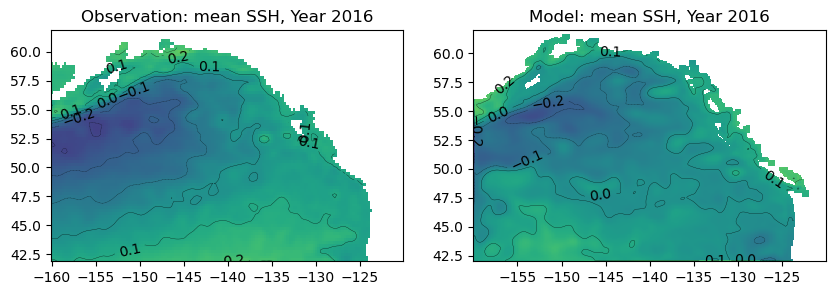

In [32]:
#
# mean SSH field for the specific year
# background constant value has been subtracted
#
# Creating a figure with a size of 10x3 inches
fig = plt.figure(figsize=(10, 3))

# Creating subplots with 1 row and 2 columns
ax = fig.subplots(1, 2)

# Setting up contour levels
lab = np.arange(-0.5, 0.6, 0.1)

# Adjusting mean sea surface height (SSH) by subtracting the mean value
mssh_o = mssh_o - np.nanmean(mssh_o.flatten())

# Plotting the observed mean SSH
ax[0].pcolormesh(xo, yo, mssh_o, vmin=-0.5, vmax=0.5)
cs = ax[0].contour(xo, yo, mssh_o, lab, colors='k', linewidths=0.2)
ax[0].clabel(cs)  # Adding contour labels
ax[0].set_title(f'Observation: mean SSH, Year {year}')

# Adjusting mean SSH from the model by subtracting the mean value
mssh_m = mssh_m - np.nanmean(mssh_m.flatten())

# Plotting the modeled mean SSH
ax[1].pcolormesh(xm, ym, mssh_m, vmin=-0.5, vmax=0.5)
cs = ax[1].contour(xm, ym, mssh_m, lab, colors='k', linewidths=0.2)
ax[1].clabel(cs)  # Adding contour labels
ax[1].set_title(f'Model: mean SSH, Year {year}')

Text(0.5, 1.0, 'Model: stdev SSH, Year 2016')

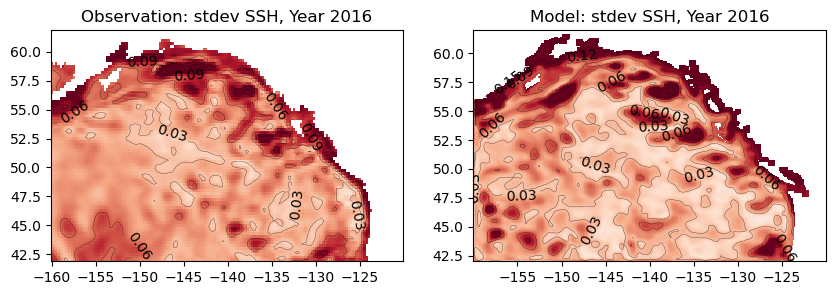

In [33]:
#
# SSH standard deviation for the specific year
#
# Creating a figure with a size of 10x3 inches
fig = plt.figure(figsize=(10, 3))

# Creating subplots with 1 row and 2 columns
ax = fig.subplots(1, 2)

# Calculating the square root of variance of sea surface height (SSH)
sssh_o = np.sqrt(vssh_o)  # Square root of variance from observations
sssh_m = np.sqrt(vssh_m)  # Square root of variance from the model

# Setting up contour levels
lab = np.arange(0, 12, 0.03)

# Plotting the square root of variance for observations
ax[0].pcolormesh(xo, yo, sssh_o, vmin=-0.1, vmax=0.1, cmap='RdBu_r')
cs = ax[0].contour(xo, yo, sssh_o, lab, colors='k', linewidths=0.2)
ax[0].clabel(cs)  # Adding contour labels
ax[0].set_title(f'Observation: stdev SSH, Year {year}')

# Plotting the square root of variance for the model
ax[1].pcolormesh(xm, ym, sssh_m, vmin=-0.1, vmax=0.1, cmap='RdBu_r')
cs = ax[1].contour(xm, ym, sssh_m, lab, colors='k', linewidths=0.2)
ax[1].clabel(cs)  # Adding contour labels
ax[1].set_title(f'Model: stdev SSH, Year {year}')

In [39]:
# Selecting sea surface temperature (SST) data from the HadISST dataset within the specified time range and spatial bounds
sst_had = ds_h.sst.sel(time=slice(time_pd[0], time_pd[-1])).sel(longitude=slice(-160, -120)).sel(latitude=slice(62, 42))

# Calculating the mean SST over time
sst_had = sst_had.mean('time')


In [40]:
# Extracting sea surface temperature (SST) data from the model dataset
SST_model0 = ds0.THETA[:, 0, :, :].mean('time').to_numpy()

# Handling missing values in the model SST data by replacing zeros with NaN
SST_model0 = np.where(SST_model0 == 0, np.nan, SST_model0)

# Extracting sea surface temperature (SST) data from the World Ocean Atlas dataset for the Gulf of Alaska region
SST_woa = ds_t_goa.t_an[0, 0, :, :].to_numpy()

Text(0.5, 1.0, 'SST: Model, hindcast, 1991-2022')

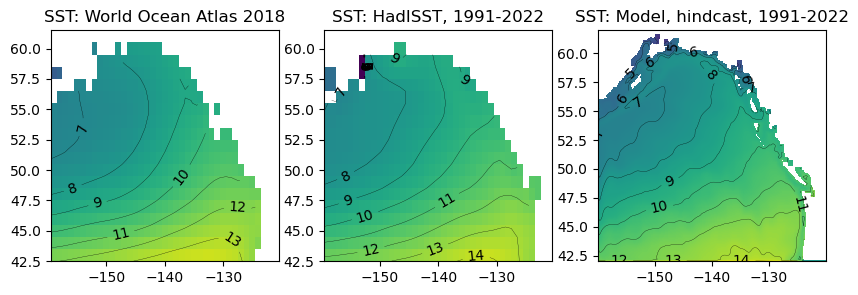

In [41]:
# Creating a figure with a size of 10x3 inches
fig = plt.figure(figsize=(10, 3))

# Creating subplots with 1 row and 3 columns
ax = fig.subplots(1, 3)

# Setting up contour levels
lab = np.arange(0, 15, 1)

# Plotting SST from World Ocean Atlas 2018
x = ds_t_goa.lon.to_numpy()
y = ds_t_goa.lat.to_numpy()
ax[0].pcolormesh(x, y, SST_woa, vmin=0, vmax=15)
cs = ax[0].contour(x, y, SST_woa, lab, colors='k', linewidths=0.2)
ax[0].clabel(cs)
ax[0].set_title('SST: World Ocean Atlas 2018')

# Plotting SST from HadISST dataset
xh = sst_had.longitude.to_numpy()
yh = sst_had.latitude.to_numpy()
sst0 = sst_had.to_numpy()
ax[1].pcolormesh(xh, yh, sst0, vmin=0, vmax=15)
cs = ax[1].contour(xh, yh, sst0, lab, colors='k', linewidths=0.2)
ax[1].clabel(cs)
ax[1].set_title('SST: HadISST, ' + yrange)

# Plotting model SST data
x = ds0.XC.to_numpy() - 360
y = ds0.YC.to_numpy()
im = ax[2].pcolormesh(x, y, SST_model0, vmin=0, vmax=15)
cs = ax[2].contour(x, y, SST_model0, lab, colors='k', linewidths=0.2)
ax[2].clabel(cs)
ax[2].set_title('SST: Model, hindcast, ' + yrange)


In [42]:
# Extracting sea surface salinity (SSS) data from the model dataset
SSS_model0 = ds0.SALT[:, 0, :, :].mean('time').to_numpy()

# Handling missing values in the model SSS data by replacing zeros with NaN
SSS_model0 = np.where(SSS_model0 == 0, np.nan, SSS_model0)

# Extracting sea surface salinity (SSS) data from the World Ocean Atlas dataset for the Gulf of Alaska region
SSS_woa = ds_s_goa.s_an[0, 0, :, :].to_numpy()

Text(0.5, 1.0, 'SSS: Model, hindcast, 1991-2022')

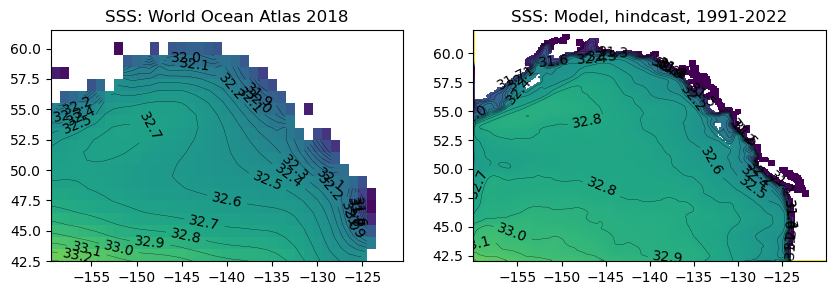

In [43]:
# Creating a figure with a size of 10x3 inches
fig = plt.figure(figsize=(10, 3))

# Creating subplots with 1 row and 2 columns
ax = fig.subplots(1, 2)

# Setting up contour levels
lab = np.arange(31, 34, 0.1)

# Plotting SSS from World Ocean Atlas 2018
x = ds_s_goa.lon.to_numpy()
y = ds_s_goa.lat.to_numpy()
ax[0].pcolormesh(x, y, SSS_woa, vmin=31, vmax=34)
cs = ax[0].contour(x, y, SSS_woa, lab, colors='k', linewidths=0.2)
ax[0].clabel(cs)
ax[0].set_title('SSS: World Ocean Atlas 2018')

# Plotting model SSS data
x = ds0.XC.to_numpy() - 360
y = ds0.YC.to_numpy()
im = ax[1].pcolormesh(x, y, SSS_model0, vmin=31, vmax=34)
cs = ax[1].contour(x, y, SSS_model0, lab, colors='k', linewidths=0.2)
ax[1].clabel(cs)
ax[1].set_title('SSS: Model, hindcast, ' + yrange)


In [44]:
# Extracting mean sea surface height (eta) data from the model dataset
eta = ds0.ETAN.mean('time').to_numpy()

# Extracting mean zonal velocity (u) data from the model dataset for the upper 150m
u = ds0.UVEL.mean('time').sel(Z=slice(0, -150)).mean('Z').to_numpy()

# Extracting mean meridional velocity (v) data from the model dataset for the upper 150m
v = ds0.VVEL.mean('time').sel(Z=slice(0, -150)).mean('Z').to_numpy()


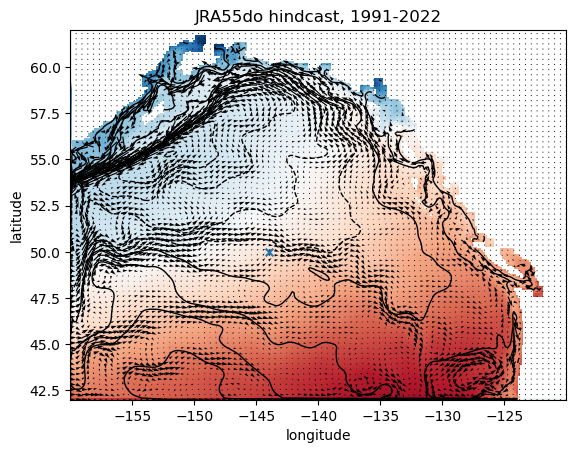

In [45]:
# Plotting SST, SSH, and velocity together

# SST data
sst = SST_model0

# Set land values in SSH data to NaN
eta[eta == 0] = np.nan

# Contour interval for SSH
cr = np.arange(-1, 1, 0.05)

# Color plot for SST
plt.pcolormesh(x, y, sst, cmap='RdBu_r')

# Contour plot for SSH
plt.contour(x, y, eta, cr, linewidths=1, colors='k')

# Quiver plot for velocity
m = 3
plt.quiver(x[::m], y[::m], u[::m, ::m], v[::m, ::m])

# Axis labels
plt.xlabel('longitude')
plt.ylabel('latitude')

# Place a dot for a specific location (OSP)
plt.scatter(-144, 50, 30, marker='x')

# Plot title and additional labels
plt.title('JRA55do hindcast, ' + yrange)
plt.xlabel('longitude')
plt.ylabel('latitude')

# Display the plot
plt.show()
